### Ambiente linux anaconda YouTube


https://developers.google.com/meridian/notebook/meridian-getting-started

https://github.com/google/meridian/tree/main/meridian/data


https://www.youtube.com/watch?v=KhXeE3aI3fo

https://www.enricopavan.com/google-meridian-analizzare-ottimizzare-budget-marketing/?utm_source=youtube&utm_medium=organic-social&utm_campaign=GoogleMeridian&utm_id=yt05


https://medium.com/towards-data-science/new-generation-marketing-mix-modelling-with-meridian-e831a0906b40

MMM - Marketing Mix Modeling is an old statistical approach that tries to understand the impact of marketing campaigns on KPIs such as sales, conversions and traffic.

Every MMM model is basically a regression, in which the regressors (marketing activities and spends, macro-economic factors, seasonality, etc) are fitted vs the target to predict. The obtained coefficients are then used to compute ROI (Return-on-investment) and other efficiency KPIs, eg:

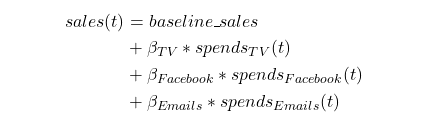


MMM approaches can be used to understand the past and make scenarios for the future. Knowing the impact of your marketing campaigns can help to guide budget allocation decisions, and answer questions like :

How did the marketing channels drive my revenue or other KPI?

What was my marketing return on investment (ROI)?

How do I optimize my marketing budget allocation for the future?




How does Meridian differ from previous MMM ?

### A Bayesian framework

Traditional MMM often use standard regression techniques based on what is called Maximum Likelihood Estimate. This often requires a lot of data to be stable, and provides no information about uncertainty. Traditional MMM regressions provide point estimates, meaning that if our goal is to estimate the coefficients β of each marketing channel (roughly equivalent to our marginal ROI), we would get a scalar value (1.2, 10.5, -2.3, etc…).

Bayesian MMM rely on a different approach which uses Bayes theorem and Markov Chain Monte Carlo sampling to estimate our parameters β. But instead of having a scalar value, we get distributions over our parameters. This becomes handy because we can have access to a range of credible value for our parameters, take the mean if we need a value, or a percentile, and get a notion of the standard deviation to represent the uncertainty around our parameter.


Imagine you are asking a frequentist and a bayesian about tomorrow’s temperature:

Frequentist : tomorrow’s forecasted temperature is 12.5 °C

Bayesian : tomorrow’s forecasted temperature is a gaussian centered around 11.5 °C with a standard deviation of 1.2°C.

In [1]:
##!pip install google-meridian==1.0.0

In [2]:
import pandas as pd

raw_df = pd.read_csv("data.csv")
raw_df

,wk_strt_dt,yr_nbr,qtr_nbr,prd,wk_nbr,wk_in_yr_nbr,mdip_dm,mdip_inst,mdip_nsp,mdip_auddig,...,seas_prd_12,seas_week_40,seas_week_41,seas_week_42,seas_week_43,seas_week_44,seas_week_45,seas_week_46,seas_week_47,seas_week_48
0,2014-08-03,2014,3,7,1,27,4863885,29087520,2421933,692315,...,0,0,0,0,0,0,0,0,0,0
1,2014-08-10,2014,3,7,2,28,20887502,8345120,3984494,475810,...,0,0,0,0,0,0,0,0,0,0
2,2014-08-17,2014,3,7,3,29,11097724,17276800,1846832,784732,...,0,0,0,0,0,0,0,0,0,0
3,2014-08-24,2014,3,7,4,30,1023446,18468480,2394834,1032301,...,0,0,0,0,0,0,0,0,0,0
4,2014-08-31,2014,3,8,1,31,21109811,26659920,3312008,400456,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,2018-07-01,2018,2,5,5,22,13038,13828188,387,2135131,...,0,0,0,0,0,0,0,0,0,0
205,2018-07-08,2018,2,6,1,23,0,3714294,0,1448480,...,0,0,0,0,0,0,0,0,0,0
206,2018-07-15,2018,2,6,2,24,2225092,5102353,0,1307764,...,0,0,0,0,0,0,0,0,0,0
207,2018-07-22,2018,2,6,3,25,17544331,1478566,1891,510539,...,0,0,0,0,0,0,0,0,0,0



# Step 1: Load the data

Load the simulated dataset in CSV format as follows.

https://github.com/google/meridian/blob/main/meridian/data/simulated_data/csv/geo_all_channels.csv (muito grande na hora de rodar, mesmo com o (n_chains=2 )

1. Map the column names to their corresponding variable types. For example, the column names 'GQV' and 'Competitor_Sales' are mapped to controls. The required variable types are time, controls, population, kpi, revenue_per_kpi, media and spend. If your data includes organic media or non-media treatments, you can add them using organic_media and non_media_treatments arguments. For the definition of each variable, see Collect and organize your data.

https://developers.google.com/meridian/docs/user-guide/collect-data?hl=pt-br

In [3]:
raw_df.columns



Index(['wk_strt_dt', 'yr_nbr', 'qtr_nbr', 'prd', 'wk_nbr', 'wk_in_yr_nbr',
       'mdip_dm', 'mdip_inst', 'mdip_nsp', 'mdip_auddig', 'mdip_audtr',
       'mdip_vidtr', 'mdip_viddig', 'mdip_so', 'mdip_on', 'mdip_em',
       'mdip_sms', 'mdip_aff', 'mdip_sem', 'mdsp_dm', 'mdsp_inst', 'mdsp_nsp',
       'mdsp_auddig', 'mdsp_audtr', 'mdsp_vidtr', 'mdsp_viddig', 'mdsp_so',
       'mdsp_on', 'mdsp_sem', 'sales', 'me_ics_all', 'me_gas_dpg', 'st_ct',
       'mrkdn_valadd_edw', 'mrkdn_pdm', 'va_pub_0.15', 'va_pub_0.2',
       'va_pub_0.25', 'va_pub_0.3', 'hldy_Black Friday', 'hldy_Christmas Day',
       'hldy_Christmas Eve', 'hldy_Columbus Day', 'hldy_Cyber Monday',
       'hldy_Day after Christmas', 'hldy_Easter', 'hldy_Father's Day',
       'hldy_Green Monday', 'hldy_July 4th', 'hldy_Labor Day', 'hldy_MLK',
       'hldy_Memorial Day', 'hldy_Mother's Day', 'hldy_NYE',
       'hldy_New Year's Day', 'hldy_Pre Thanksgiving', 'hldy_Presidents Day',
       'hldy_Prime Day', 'hldy_Thanksgiving', 'hl

# Loading the data
 In our use case, we will only use the spends from 5 channels: Newspaper, Radio, TV, Social Media and Online Display.

In [4]:
# 1. control variables
CONTROL_COLS = [col for col in raw_df.columns if 'hldy_' in col]


# 2. media variables
spends_mapping = {
    "mdsp_nsp": "Newspaper",
    "mdsp_audtr": "Radio",
    "mdsp_vidtr": "TV",
    "mdsp_so": "Social Media",
    "mdsp_on": "Online Display",
}
MEDIA_COLS = list(spends_mapping.keys())


# 3. sales variables
SALES_COL = "sales"

# 4. Date column
DATE_COL = "wk_strt_dt"
data_df = raw_df[[DATE_COL, SALES_COL, *MEDIA_COLS, *CONTROL_COLS]]
data_df[DATE_COL] = pd.to_datetime(data_df[DATE_COL])

/tmp/ipykernel_4824/158992229.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df[DATE_COL] = pd.to_datetime(data_df[DATE_COL])


In [5]:
MEDIA_COLS

['mdsp_nsp', 'mdsp_audtr', 'mdsp_vidtr', 'mdsp_so', 'mdsp_on']

## COluna oficial

In [6]:
data_df

,wk_strt_dt,sales,mdsp_nsp,mdsp_audtr,mdsp_vidtr,mdsp_so,mdsp_on,hldy_Black Friday,hldy_Christmas Day,hldy_Christmas Eve,...,hldy_Memorial Day,hldy_Mother's Day,hldy_NYE,hldy_New Year's Day,hldy_Pre Thanksgiving,hldy_Presidents Day,hldy_Prime Day,hldy_Thanksgiving,hldy_Valentine's Day,hldy_Veterans Day
0,2014-08-03,7.205146e+07,507635.16,254134.14,216725.59,0.00,61364.75,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2014-08-10,7.879477e+07,625719.37,106602.98,108919.26,0.00,132643.90,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2014-08-17,7.007119e+07,277532.61,59011.42,74032.19,0.00,76741.27,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2014-08-24,6.864246e+07,186028.61,178010.46,110995.66,0.00,193043.55,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2014-08-31,8.619078e+07,706694.09,144097.56,225140.84,0.00,249612.89,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,2018-07-01,6.671739e+07,247.54,81629.95,106915.43,127450.10,367134.78,0,0,0,...,0,0,0,0,0,0,0,0,0,0
205,2018-07-08,1.174300e+08,0.00,108353.11,38880.62,51395.55,229922.46,0,0,0,...,0,0,0,0,0,0,1,0,0,0
206,2018-07-15,6.403861e+07,0.00,138260.98,58461.70,123897.22,147652.74,0,0,0,...,0,0,0,0,0,0,0,0,0,0
207,2018-07-22,5.356965e+07,564.40,67235.71,13895.66,136457.71,143210.12,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
data_df.loc[data_df['hldy_Black Friday']==1]

,wk_strt_dt,sales,mdsp_nsp,mdsp_audtr,mdsp_vidtr,mdsp_so,mdsp_on,hldy_Black Friday,hldy_Christmas Day,hldy_Christmas Eve,...,hldy_Memorial Day,hldy_Mother's Day,hldy_NYE,hldy_New Year's Day,hldy_Pre Thanksgiving,hldy_Presidents Day,hldy_Prime Day,hldy_Thanksgiving,hldy_Valentine's Day,hldy_Veterans Day
16,2014-11-23,1.529326e+08,1207930.38,179152.14,392581.65,128992.07,397679.40,1,0,0,...,0,0,0,0,1,0,0,1,0,0
68,2015-11-22,2.596200e+08,488971.65,145388.82,593434.80,413630.65,426266.91,1,0,0,...,0,0,0,0,1,0,0,1,0,0
120,2016-11-20,2.657882e+08,361914.91,139059.45,297054.69,573355.55,444669.29,1,0,0,...,0,0,0,0,1,0,0,1,0,0
172,2017-11-19,1.710185e+08,160905.89,122408.80,410842.55,411024.47,396876.12,1,0,0,...,0,0,0,0,1,0,0,1,0,0


In [8]:

raw_df.loc[raw_df['hldy_Black Friday']==1]

,wk_strt_dt,yr_nbr,qtr_nbr,prd,wk_nbr,wk_in_yr_nbr,mdip_dm,mdip_inst,mdip_nsp,mdip_auddig,...,seas_prd_12,seas_week_40,seas_week_41,seas_week_42,seas_week_43,seas_week_44,seas_week_45,seas_week_46,seas_week_47,seas_week_48
16,2014-11-23,2014,4,10,4,43,17551954,62803626,6880524,929317,...,0,0,0,0,1,0,0,0,0,0
68,2015-11-22,2015,4,10,4,43,27078329,44471116,2248483,961349,...,0,0,0,0,1,0,0,0,0,0
120,2016-11-20,2016,4,10,4,43,600592,34793593,1084460,788270,...,0,0,0,0,1,0,0,0,0,0
172,2017-11-19,2017,4,10,4,43,354083,26107600,938727,2016339,...,0,0,0,0,1,0,0,0,0,0


In [9]:


# (controls) Variáveis de controle  Contém os fatores de confusão que têm um efeito causal no KPI desejado e na métrica de mídia, como o volume de consultas do Google (GQV, na sigla em inglês). A seleção dessas variáveis é importante para estimar o efeito causal de uma MMM. Consulte o artigo Gráfico causal.

# KPI O KPI desejado que o modelo vai prever. Por exemplo, o valor da receita ou o número de instalações do aplicativo. E também é a variável de resposta da MMM.

#(revenue_per_kpi) Receita por KPI  Contém a receita média por unidade de KPI. Na ausência de um valor preciso, recomendamos aproximar um valor lógico. Se essas informações não estiverem disponíveis, consulte Valor do KPI desconhecido. Se a receita for seu KPI, essa métrica não será necessária.

# (population) População geográfica Contém a população de cada região geográfica. Essa informação (como a população de domicílios da DMA com TV da Nielsen) é usada para dimensionar a métrica de mídia e colocar todas as localidades em uma escala comparável. Consulte Dados de entrada para mais detalhes sobre o dimensionamento de mídia.

# (media) Dados de mídia  Contém a métrica de exposição por canal e período (como impressões por período). Os valores de mídia não podem ser negativos. Quando as métricas de exposição não estiverem disponíveis, use as mesmas do gasto de mídia.

#(media_spend) Gasto de mídia Contém os gastos por canal e período. Os dados e os gastos de mídia precisam ter as mesmas dimensões.

# (organic_media) Mídia orgânica: As variáveis de mídia orgânica são atividades de mídia que não têm custo direto. Isso pode incluir, sem limitação, impressões de newsletters, postagens de blogs, atividades em redes sociais ou campanhas por e-mail.
# (non_media_treatments) Tratamentos que não são de mídia:  Essas variáveis são atividades de marketing que não estão diretamente relacionadas à mídia, como a realização de uma promoção, o preço de um produto e uma mudança na embalagem ou no design de um item.

# https://developers.google.com/meridian/docs/user-guide/collect-data?hl=pt-br

In [10]:
# controls
# (controls) Variáveis de controle  Contém os fatores de confusão que têm um efeito causal no KPI 
#desejado e na métrica de mídia, como o volume de consultas do Google (GQV, na sigla em inglês). 
#A seleção dessas variáveis é importante para estimar o efeito causal de uma MMM. Consulte o artigo Gráfico causal.

CONTROL_COLS

['hldy_Black Friday',
 'hldy_Christmas Day',
 'hldy_Christmas Eve',
 'hldy_Columbus Day',
 'hldy_Cyber Monday',
 'hldy_Day after Christmas',
 'hldy_Easter',
 "hldy_Father's Day",
 'hldy_Green Monday',
 'hldy_July 4th',
 'hldy_Labor Day',
 'hldy_MLK',
 'hldy_Memorial Day',
 "hldy_Mother's Day",
 'hldy_NYE',
 "hldy_New Year's Day",
 'hldy_Pre Thanksgiving',
 'hldy_Presidents Day',
 'hldy_Prime Day',
 'hldy_Thanksgiving',
 "hldy_Valentine's Day",
 'hldy_Veterans Day']

In [11]:
#time
DATE_COL

'wk_strt_dt'

In [12]:
# KPI O KPI desejado que o modelo vai prever. Por exemplo, o valor da receita ou o número de instalações do aplicativo. E também é a variável de resposta da MMM.

SALES_COL

'sales'

In [13]:
# (media) Dados de mídia  Contém a métrica de exposição por canal e período (como impressões por período). 
#Os valores de mídia não podem ser negativos. Quando as métricas de exposição não estiverem disponíveis, use as mesmas do gasto de mídia.
MEDIA_COLS

['mdsp_nsp', 'mdsp_audtr', 'mdsp_vidtr', 'mdsp_so', 'mdsp_on']

In [14]:
#    "mdsp_nsp": "Newspaper",
#    "mdsp_audtr": "Radio",
#    "mdsp_vidtr": "TV",
#    "mdsp_so": "Social Media",
#    "mdsp_on": "Online Display",


In [15]:
#(media_spend) Gasto de mídia Contém os gastos por canal e período. Os dados e os gastos de mídia precisam ter as mesmas dimensões.
MEDIA_COLS

['mdsp_nsp', 'mdsp_audtr', 'mdsp_vidtr', 'mdsp_so', 'mdsp_on']

2. Map the media variables and the media spends to the designated channel names intended for display in the two-page HTML output. In the following example, 'Channel0_impression' and 'Channel0_spend' are connected to the same channel, 'Channel0'.

In [16]:
spends_mapping

{'mdsp_nsp': 'Newspaper',
 'mdsp_audtr': 'Radio',
 'mdsp_vidtr': 'TV',
 'mdsp_so': 'Social Media',
 'mdsp_on': 'Online Display'}

In [17]:
from meridian.data import load

coord_to_columns = load.CoordToColumns(
    time=DATE_COL,
    controls=CONTROL_COLS,
    kpi=SALES_COL,
    media=MEDIA_COLS,
    media_spend=MEDIA_COLS,
)  

2025-02-09 19:31:00.100765: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-09 19:31:00.106923: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-09 19:31:00.156628: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-09 19:31:00.223116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-09 19:31:00.282121: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

3. Load the CSV data using CsvDataLoader. Note that csv_path is the path to the data file location.

In [18]:
coord_to_columns

CoordToColumns(controls=['hldy_Black Friday', 'hldy_Christmas Day', 'hldy_Christmas Eve', 'hldy_Columbus Day', 'hldy_Cyber Monday', 'hldy_Day after Christmas', 'hldy_Easter', "hldy_Father's Day", 'hldy_Green Monday', 'hldy_July 4th', 'hldy_Labor Day', 'hldy_MLK', 'hldy_Memorial Day', "hldy_Mother's Day", 'hldy_NYE', "hldy_New Year's Day", 'hldy_Pre Thanksgiving', 'hldy_Presidents Day', 'hldy_Prime Day', 'hldy_Thanksgiving', "hldy_Valentine's Day", 'hldy_Veterans Day'], time='wk_strt_dt', kpi='sales', revenue_per_kpi=None, geo='geo', population='population', media=['mdsp_nsp', 'mdsp_audtr', 'mdsp_vidtr', 'mdsp_so', 'mdsp_on'], media_spend=['mdsp_nsp', 'mdsp_audtr', 'mdsp_vidtr', 'mdsp_so', 'mdsp_on'], reach=None, frequency=None, rf_spend=None, non_media_treatments=None, organic_media=None, organic_reach=None, organic_frequency=None)

In [19]:
spends_mapping

{'mdsp_nsp': 'Newspaper',
 'mdsp_audtr': 'Radio',
 'mdsp_vidtr': 'TV',
 'mdsp_so': 'Social Media',
 'mdsp_on': 'Online Display'}

In [20]:
loader = load.DataFrameDataLoader(
    df=data_df,
    kpi_type='revenue',
    coord_to_columns=coord_to_columns,
    media_to_channel=spends_mapping,
    media_spend_to_channel=spends_mapping
)
data = loader.load()

/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/meridian/data/load.py:828: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[time_column_name] = self.df[time_column_name].map(
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/meridian/data/load.py:882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df[geo_column_name] = constants.NATIONAL_MODEL_DEFAULT_GEO_NAME
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/meridian/data/load.py:885: SettingWithCo

In [21]:
data

InputData(kpi=<xarray.DataArray 'kpi' (geo: 1, time: 209)> Size: 2kB
array([[7.20514576e+07, 7.87947705e+07, 7.00711856e+07, 6.86424646e+07,
        8.61907847e+07, 5.61206164e+07, 1.25634433e+08, 1.10756936e+08,
        1.16192535e+08, 1.29263590e+08, 1.42052816e+08, 7.17540438e+07,
        1.23589120e+08, 7.75875339e+07, 1.53818240e+08, 1.88168749e+08,
        1.52932619e+08, 3.07377804e+08, 1.64024324e+08, 3.51597977e+08,
        3.23162004e+08, 1.06476774e+08, 1.06622601e+08, 6.34607874e+07,
        5.35035583e+07, 9.85468295e+07, 6.67747051e+07, 8.36661340e+07,
        7.30903785e+07, 1.11100800e+08, 6.47450530e+07, 7.07741382e+07,
        1.30727969e+08, 7.16337108e+07, 8.89227392e+07, 6.57779340e+07,
        7.50164974e+07, 9.64383560e+07, 1.90030036e+08, 1.06526801e+08,
        7.20851096e+07, 7.44219030e+07, 1.32061381e+08, 7.76905961e+07,
        1.19823112e+08, 9.66654862e+07, 6.32965036e+07, 1.22461146e+08,
        6.96123547e+07, 6.17227566e+07, 6.05849345e+07, 9.62758403e

# Exploring the data
Sales

In [22]:
#from config import COLORS


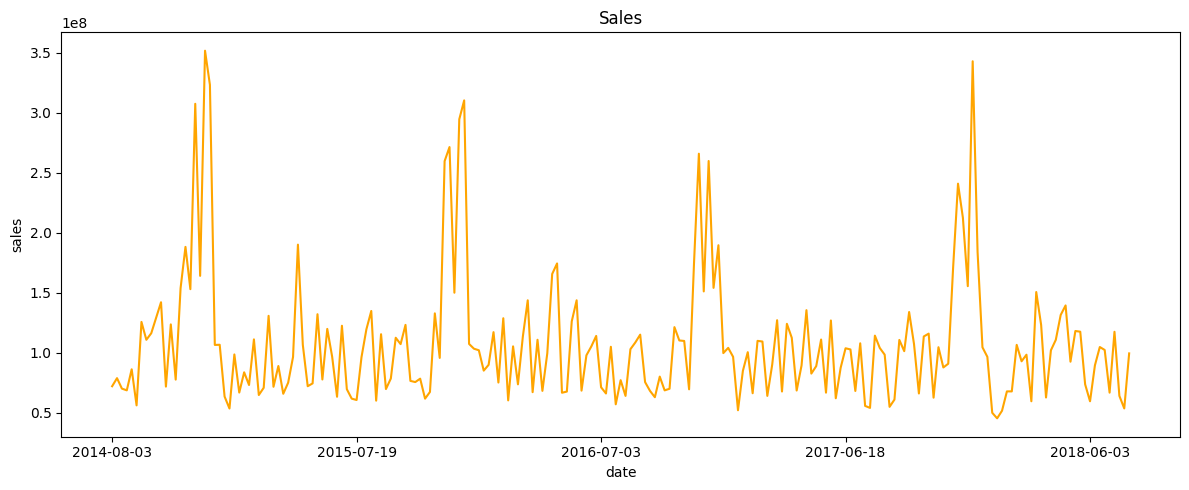

In [23]:
import matplotlib.pyplot as plt
COLORS = ["blue", "orange", "green", "red", "purple"]  # Exemplo de cores
# fig, ax = plt.subplots()
fig, ax = plt.subplots(figsize=(12, 5))  # Ajusta o tamanho



data_df.set_index("wk_strt_dt")[SALES_COL].plot(color=COLORS[1], ax=ax)
ax.set(title="Sales", xlabel='date', ylabel="sales");
fig.tight_layout();

Media Spends



In [24]:
spends_mapping

{'mdsp_nsp': 'Newspaper',
 'mdsp_audtr': 'Radio',
 'mdsp_vidtr': 'TV',
 'mdsp_so': 'Social Media',
 'mdsp_on': 'Online Display'}

In [25]:
spends_columns_raw = ['mdsp_nsp',
 'mdsp_audtr',
 'mdsp_vidtr',
 'mdsp_so',
 'mdsp_on']

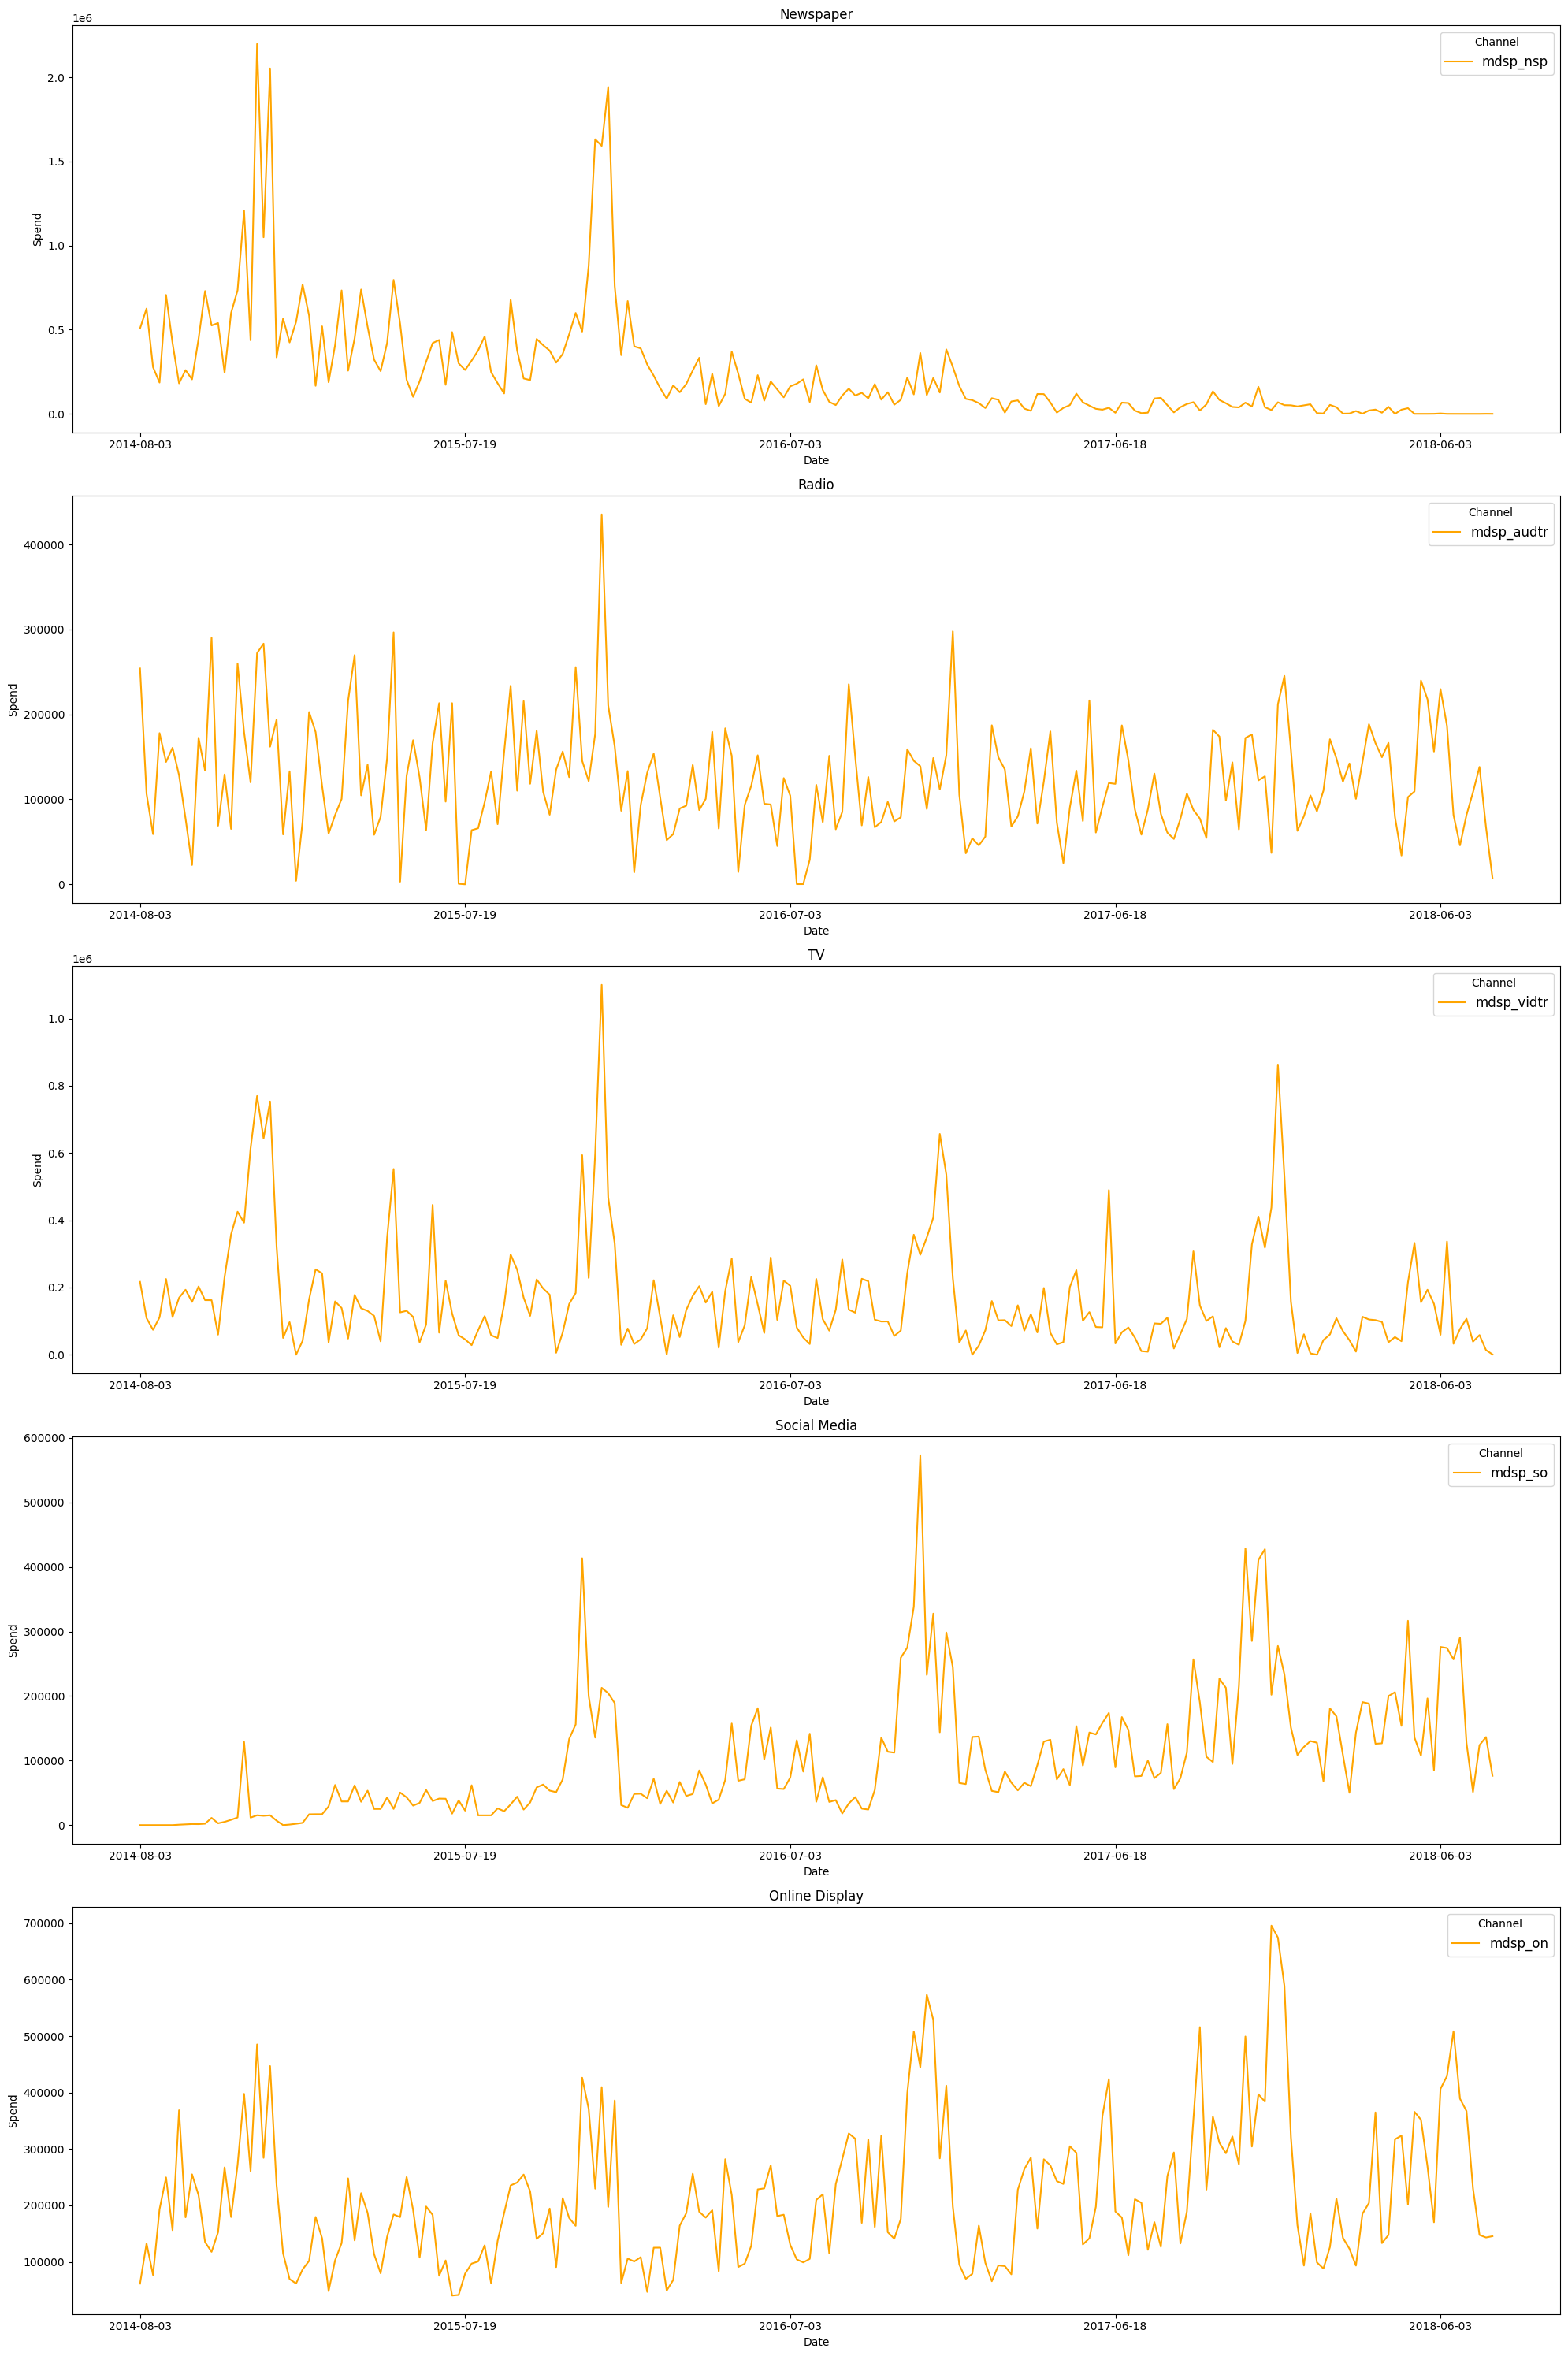

In [26]:
fig, ax = plt.subplots(5, figsize=(20,30))

for axis, channel in zip(ax, spends_columns_raw):
    data_df.set_index("wk_strt_dt")[channel].plot(ax=axis, color=COLORS[1])
    axis.legend(title="Channel", fontsize=12)
    axis.set(title=spends_mapping[channel], xlabel="Date", ylabel="Spend");
fig.tight_layout()

# Specifying the Model


Note that the simulated data here does not contain reach and frequency. We recommend including reach and frequency data whenever they are available. For information about the advantages of utilizing reach and frequency, see Bayesian Hierarchical Media Mix Model Incorporating Reach and Frequency Data. For code snippet for loading reach and frequency data, see Load geo-level data with reach and frequency

https://research.google/pubs/bayesian-hierarchical-media-mix-model-incorporating-reach-and-frequency-data/#:%7E:text=By%20incorporating%20R%26F%20into%20MMM,based%20on%20optimal%20frequency%20recommendations.

The documentation provides guidance for instances where reach and frequency data is accessible for specific channels. Additionally, for information about how to load other data types and formats, including data with reach and frequency, see Supported data types and formats.

# Step 2: Configure the model


Meridian uses Bayesian framework and Markov Chain Monte Carlo (MCMC) algorithms to sample from the posterior distribution.

1. Inititalize the Meridian class by passing the loaded data and the customized model specification. One advantage of Meridian lies in its capacity to calibrate the model directly through ROI priors, as described in Media Mix Model Calibration With Bayesian Priors. In this particular example, the ROI priors for all media channels are identical, with each being represented as Lognormal(0.2, 0.9).

https://research.google/pubs/media-mix-model-calibration-with-bayesian-priors/

In [27]:
#roi_mu = 0.2     # Mu for ROI prior for each media channel.
#roi_sigma = 0.9  # Sigma for ROI prior for each media channel.
#prior = prior_distribution.PriorDistribution(
#    roi_m=tfp.distributions.LogNormal(roi_mu, roi_sigma, name=constants.ROI_M)
#)
#model_spec = spec.ModelSpec(prior=prior)
#mmm = model.Meridian(input_data=data, model_spec=model_spec)


In [28]:
import tensorflow_probability as tfp
from meridian import constants
from meridian.model import prior_distribution


prior = prior_distribution.PriorDistribution(
    beta_m=tfp.distributions.HalfNormal(
        0.2, 
        name=constants.BETA_M,
    # If you want to use the ROI vision instead of the coefficients approach
    # roi_m=tfp.distributions.HalfNormal(
    #     0.2, 
    #     name=constants.ROI_M
    )
)

In [29]:
from meridian.model import spec
from meridian.model import model

model_spec = spec.ModelSpec(
    prior=prior,
    max_lag=6,
    knots=int(0.1*len(data_df)),
    paid_media_prior_type='coefficient',
)
mmm = model.Meridian(input_data=data, model_spec=model_spec)

/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/meridian/model/model.py:67: UserWarning: In a nationally aggregated model, the `media_effects_dist` will be reset to `normal`.
  warnings.warn(
I0000 00:00:1739140270.221005    4824 service.cc:145] XLA service 0x30d7ecc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739140270.221212    4824 service.cc:153]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1739140270.278621    4824 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


# Running the model
Fitting the model can be slow if you have a large number of data points and variables. I recommend to start with 2 chains, and leave the default number of samples:



In [30]:
mmm.sample_prior(500)
mmm.sample_posterior(n_chains=2, n_adapt=500, n_burnin=500, n_keep=1000)

/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/meridian/model/prior_distribution.py:846: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. tau_g_excl_baseline has been automatically set to Deterministic(0).
  warnings.warn(
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/meridian/model/prior_distribution.py:846: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_m has been automatically set to Deterministic(0).
  warnings.warn(
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/meridian/model/prior_distribution.py:846: UserWarning: Hierarchical distribution parameters must be deterministically zero for national models. eta_rf has been automatically set to Deterministic(0).
  warnings.warn(
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/meridian/model/prior_distribution.py:846: UserWarning: Hierarchical distribu

For more information about configuring the parameters and using a customized model specification, such as setting different ROI priors for each media channel, see Configure the model.


# Step 3: Run model diagnostics

    
After the model is built, you must assess convergence, debug the model if needed, and then assess the model fit.

1. Assess convergence. Run the following code to generate r-hat statistics. R-hat close to 1.0 indicate convergence. R-hat < 1.2 indicates approximate convergence and is a reasonable threshold for many problems.




# Model Diagnostics


Model Diagnostics

Once the model is done running, we will perform a series of checks to ensure that we can use it confidently.

## R-hat
R-hat close to 1.0 indicate convergence. R-hat < 1.2 indicates approximate convergence and is a reasonable threshold for many problems.

A lack of convergence typically has one of two culprits. Either the model is very poorly misspecified for the data, which can be in the likelihood (model specification) or in the prior. Or, there is not enough burnin, meaning n_adapt + n_burnin is not large enough.

In [31]:
from meridian.analysis import visualizer

model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.plot_rhat_boxplot()

/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [32]:
help(model_diagnostics.plot_rhat_boxplot)


Help on method plot_rhat_boxplot in module meridian.analysis.visualizer:

plot_rhat_boxplot() -> altair.vegalite.v4.api.Chart method of meridian.analysis.visualizer.ModelDiagnostics instance
    Plots the R-hat box plot.

    Visual summary of the Gelman & Rubin (1992) potential scale reduction for
    chain convergence, commonly referred to as R-hat. It is a convergence
    diagnostic measure that measures the degree to which variance (of the means)
    between chains exceeds what you would expect if the chains were identically
    distributed. Values close to 1.0 indicate convergence. R-hat < 1.2 indicates
    approximate convergence and is a reasonable threshold for many problems
    (Brooks & Gelman, 1998).

    There is a single R-hat value for each model parameter. The box plot
    summarizes the distribution of R-hat values across indices. For example, the
    box corresponding to `beta_gm` summarizes the distribution of R-hat values
    across both the geo index `g` and the cha

In [33]:
#!pip install altair_viewer
# para visualizar o gráfico


In [34]:
chart = model_diagnostics.plot_rhat_boxplot()  # Gera o gráfico

# Ajusta o tamanho do gráfico Altair
chart = chart.properties(width=800, height=400)  

#chart.show()  # Exibe o gráfico atualizado
display(chart)  # Exibe o gráfico inline


/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

We see that all r-hat values are below 1.02, which indicates no divergence or issue during training.



# 2. Model trace

The model trace contains the sample values from the chains. A nice trace is when the two posterior distributions (as we have 2 chains) for a given parameter overlap nicely. In the diagram below, you can see that blue and black lines on the left-hand side nicely overlap :



### 4. R2 and Model Fit

Finally, we will use metrics to evaluate our model fit. You probably know about metrics like R2, MAPE, etc., so let’s have a look at those values:

In [35]:
model_diagnostics = visualizer.ModelDiagnostics(mmm)
model_diagnostics.predictive_accuracy_table()

/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/meridian/analysis/analyzer.py:182: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(


,metric,geo_granularity,value
0,R_Squared,national,0.538551
1,MAPE,national,0.271313
2,wMAPE,national,0.252632


Obviously, a R2 of 0.54 is not great at all. We could improve that by either adding more knots in the baseline, or more data to the model, or play with the priors to try to capture more information.

Let’s now plot the model:

In [36]:
model_fit = visualizer.ModelFit(mmm)
model_fit.plot_model_fit()

/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/meridian/analysis/analyzer.py:182: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

2. Assess the model's fit by comparing the expected sales against the actual sales.


In [37]:
# Ajusta o tamanho do gráfico Altair
chart = model_fit.plot_model_fit().properties(width=800, height=400)  

#chart.show()  # Exibe o gráfico atualizado
display(chart)  # Exibe o gráfico inline


/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

# Contributions of media to sales

Remember that one of the objectives of MMM is to provide you with media contributions vs your sales. This is what we will look at with a waterfall diagram :

In [38]:
media_summary = visualizer.MediaSummary(mmm)
media_summary.plot_contribution_waterfall_chart()


/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

In [39]:
# Ajusta o tamanho do gráfico Altair
chart = media_summary.plot_contribution_waterfall_chart().properties(width=800, height=400)  

#chart.show()  # Exibe o gráfico atualizado
display(chart)  # Exibe o gráfico inline


/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

What we usually expect is to have a baseline between 60 and 80%. Keep in mind that this value can be very sensitive and depend on the model specification and parameters. I encourage you to play with different knots values and priors and see the impact it can have on the model.



# Spends vs Contributions

The spend versus contribution chart compares the spend and incremental revenue or KPI split between channels. The green bar highlights the return on investment (ROI) for each channel.

In [40]:
media_summary.plot_roi_bar_chart()


/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/meridian/analysis/analyzer.py:533: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  warnings.warn(
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/tensorflow/python/autograph/impl/api.py:371: UserWarning: Setting `use_kpi=True` has no effect when `kpi_type=REVENUE` since in this case, KPI is equal to revenue.
  return py_builtins.overload_of(f)(*args)
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.LayerChart(...)

ROI (Return-on-investment) 

We see that the highest ROI comes from Social Media, followed by TV. But this is also where the uncertainty interval is the largest. MMM is not an exact answer : it gives you values AND uncertainty associated to those. My opinion here is that uncertainty intervals are very large. Maybe we should use more sampling steps or add more variables to the model.



# Optimizing our budget


Remember that one of the objectives of the MMM is to propose an optimal allocation of spends to maximize revenue. This can be done first by looking at what we call response curves. Response curves describe the relationship between marketing spend and the resulting incremental revenue.



We can see there that :

1) incremental revenue increases as the spend increases

2) for some touchpoints like newspaper, growth is slower, meaning a 2x increase in spend will not translate to a 2x incremental revenue.

The goal of the optimization will be to take those curves and navigate to find the best combination of value that maximize our sales equation. We know that sales = f(media, control, baseline), and we are trying to find the media* values that maximize our function.

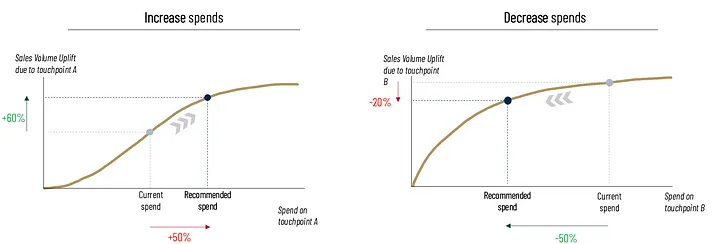


We can choose between several optimization problems, for ex:

- How can I reach the sames sales level with less budget ?

- Given the same budget, what is the maximum revenue I can get ?

Let’s use Meridian to optimize our budget and maximize sales (scenario 1). We will use the default parameters here but it is possible to fine-tune the constraints on each channel to limit the search scope.

In [41]:
from meridian.analysis import optimizer

budget_optimizer = optimizer.BudgetOptimizer(mmm)
optimization_results = budget_optimizer.optimize()

# Plot the response curves before and after 
optimization_results.plot_response_curves()

/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


alt.FacetChart(...)

## Step 4: Generate model results & two-page output
To export the two-page HTML summary output, initialize the Summarizer class with the model object. Then pass in the filename, filepath, start date, and end date to output_model_results_summary to run the summary for that time duration and save it to the specified file.

In [42]:
min(data_df['wk_strt_dt'])

'2014-08-03'

In [43]:
start_date = min(data_df['wk_strt_dt'])
end_date = max(data_df['wk_strt_dt'])

filepath = '/home/fabiene/Documentos/Fabiene/UDEMY_ML/MMM/MMM_Meridian'


In [44]:
max(data_df['wk_strt_dt'])

'2018-07-29'

In [45]:
from meridian.analysis import summarizer

mmm_summarizer = summarizer.Summarizer(mmm)


In [46]:
mmm_summarizer.output_model_results_summary('3-Exemple2summary_output.html', filepath, start_date, end_date)


/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/meridian/analysis/analyzer.py:182: UserWarning: The `aggregate_geos` argument is ignored in the national model. It will be reset to `True`.
  warnings.warn(
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/meridian/analysis/analyzer.py:182: User

# Here is a preview of the two-page output based on the simulated data:



In [47]:
import IPython

IPython.display.HTML(filename='3-Exemple2summary_output.html')


Dataset,R-squared,MAPE,wMAPE
All Data,0.54,27%,25%


https://developers.google.com/meridian/notebook/meridian-getting-started

# Step 5: Run budget optimization & generate an optimization report

You can choose what scenario to run for the budget allocation. In default scenario, you find the optimal allocation across channels for a given budget to maximize the return on investment (ROI).

1. Instantiate the BudgetOptimizer class and run the optimize() method without any customization, to run the default library's Fixed Budget Scenario to maximize ROI.

In [48]:
budget_optimizer = optimizer.BudgetOptimizer(mmm)
optimization_results = budget_optimizer.optimize()

In [49]:

optimization_results.output_optimization_summary('3-Exemple2optimization_output.html', filepath)

/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)
/home/fabiene/anaconda3/envs/YouTube/lib/python3.12/site-packages/altair/utils/core.py:384: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype

In [51]:
IPython.display.HTML(filename='3-Exemple2optimization_output.html')


Channel,Non-optimized spend,Optimized spend
TV,19%,25%
Online Display,25%,23%
Newspaper,30%,21%
Radio,14%,16%
Social Media,12%,15%


#### For information about customized optimization scenarios, such as flexible budget scenarios, see Budget optimization scenarios. For more information about optimization results summary and individual visualizations, see optimization results output and optimization visualizations.




# Step 6: Save the model object

We recommend that you save the model object for future use. This helps you to avoid repetitive model runs and saves time and computational resources. After the model object is saved, you can load it at a later stage to continue the analysis or visualizations without having to re-run the model.

Run the following codes to save the model object:




In [52]:
file_path2='/home/fabiene/Documentos/Fabiene/UDEMY_ML/MMM/MMM_Meridian/3-Exemple2saved_mmm.pkl'

model.save_mmm(mmm, file_path2)


In [53]:
## Run the following codes to load the saved model:

mmm = model.load_mmm(file_path2)
